In [1]:
%matplotlib notebook
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
eventos = pd.read_pickle("./datasets/evento.pkl")
acessos = pd.read_pickle("./datasets/acesso.pkl")

In [3]:
eventos.groupby("id_consumidor_ecommerce").agg({"id_evento": "count"}).reset_index().shape

(427, 2)

In [4]:
consumidor_evento = eventos.groupby("id_consumidor_ecommerce").agg({
    "id_evento" : "count",
    "preco" : "sum",
}).reset_index()

consumidor_acessos = acessos.groupby("id_consumidor_ecommerce").agg({ "id_acessos": "count" }).reset_index()

In [5]:
vendas_acessos = consumidor_evento.join(
    consumidor_acessos.set_index("id_consumidor_ecommerce"), on = "id_consumidor_ecommerce", lsuffix="_e", rsuffix="_a", how = "inner"
).reset_index()
vendas_acessos.rename(columns = { "id_evento": "count_compras", "preco": "sum_preco", "id_acessos": "count_acessos" }, inplace=True)

In [6]:
features = vendas_acessos[["count_compras", "sum_preco", "count_acessos"]]

In [7]:
features.count()

count_compras    371
sum_preco        371
count_acessos    371
dtype: int64

In [8]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.fillna(method="ffill"))

## Modelo de clusterização 

### Metricas para definir o número de clusters

<IPython.core.display.Javascript object>


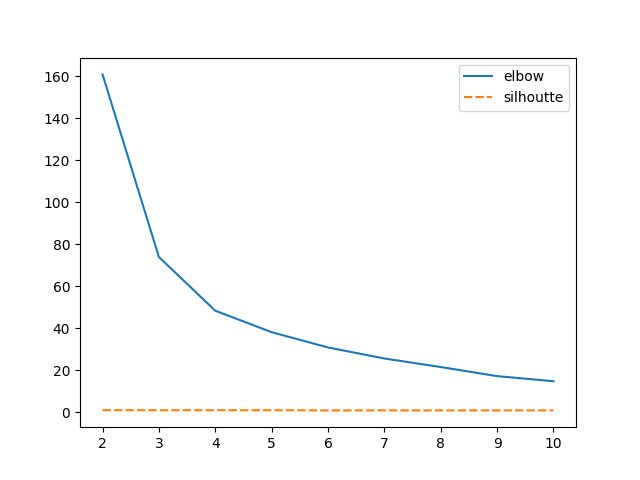

In [9]:
sse = []
silhouette_coefficients = []
k_axis = range(2, 11)
for k in k_axis:
    kmeans = KMeans(random_state=42, n_clusters=k)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)
    
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

scores = pd.DataFrame(index=k_axis, data={"elbow": sse, "silhoutte": silhouette_coefficients})
sns.lineplot(data= scores)
plt.show()

### Modelo resultante

In [10]:
# ax = sns.lineplot(data = {"k": k_axis, "silhoutte": silhouette_coefficients}, x="k", y = "silhoutte")
# plt.show()

<IPython.core.display.Javascript object>


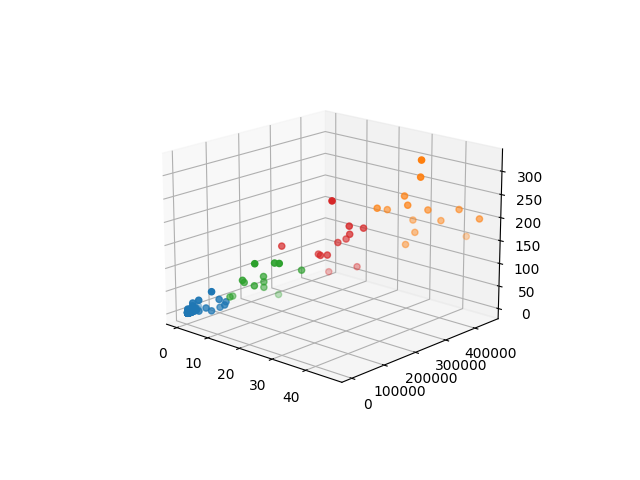

In [11]:
kmeans = KMeans(random_state=42, n_clusters=4)
kmeans.fit(scaled_features)

fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
labels = kmeans.labels_
u_labels = np.unique(labels)
for cluster in u_labels:
    ax.scatter(features.iloc[labels == cluster, 0], features.iloc[labels == cluster, 1], 
        features.iloc[labels == cluster, 2])
plt.show()

In [12]:
features = features.assign(cluster = labels)

In [13]:
from pathlib import Path
p = Path("pre_processed_data")
p.mkdir(parents = True, exist_ok = True)
features.to_pickle("./pre_processed_data/decision_tree")